<a href="https://colab.research.google.com/github/jananibalaji16/Cubstart-Homework-4/blob/main/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7: t-SNE for Dimensionality Reduction and Visualization

## 1. PCA vs t-SNE

Previously we looked at PCA as a method for dimensionality reduction by transforming data using a basis of the direction of maximum variation. Here we'll compare the two methods using the out of the box methods from scikit-learn. Make sure to fill in all TODOs!

Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Some Setup

In [ ]:
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
#we are using the MNIST dataset 
digits = load_digits()

In [ ]:
X = digits.data
y = digits.target

In [ ]:
# Scale X to be between 0 and 1 (avoid magic numbers - define global constants and use them!)

# TODO: Scale X to be between 0 and 1 (subtract minimum, divide by distance between minimum and maxium)
X = (X-np.amin(X))/(np.amax(X)-np.amin(X))

In [ ]:
# Shuffle data
X, y = shuffle(X, y)

In [ ]:
#Dataset consists of 1797 images, each of which has 64 pixels
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1797, 64)
y shape: (1797,)


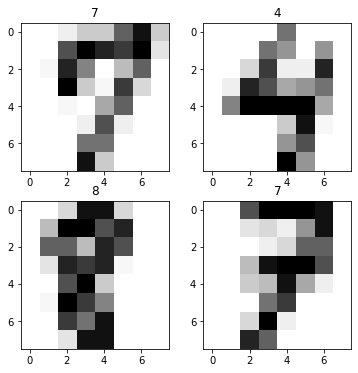

In [ ]:
# Look at the data we're working with

plt.figure(figsize=(6,6))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(y[i])    
    #TODO: Plot X[i] 
    #Hint: Use plt.imshow, reshape the image to be 8x8
    #You can set cmap to 'Greys' to have the image be in grayscale
    plt.imshow(X[i].reshape(8,8), cmap='Greys')

plt.show()

As you can see from the above code, our input data has 64 features, each resembling a pixel in each image. We want to reduce the dimensionality of our input using both PCA and t-SNE to visualize all the data points on one chart.

### 1.a) PCA

In [ ]:
# Carry out PCA on X

pca = PCA(n_components=2)
# TODO: Run PCA on X to get the first 2 principal components
pca.fit(X)
X_pca = pca.transform(X)


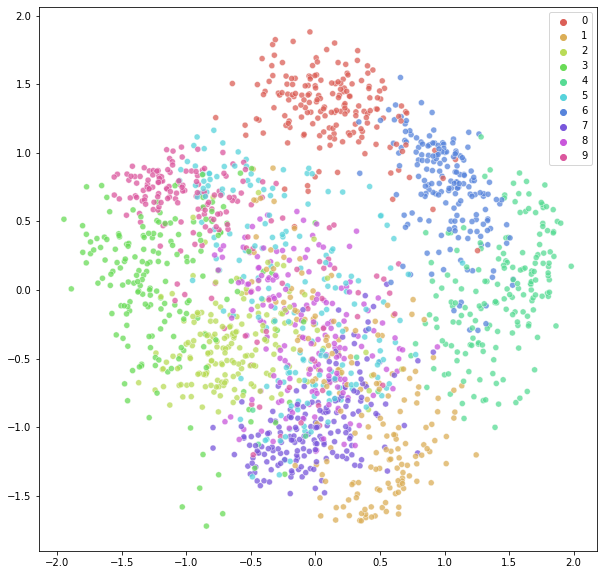

In [ ]:
# Visualize X_pca

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.show()

### 1.b) t-SNE

In [ ]:
# Carry out t-SNE on X

tsne = TSNE(n_components=2)
# TODO: Run t-SNE on X
tsne.fit(X)
X_tsne = tsne.fit_transform(X)

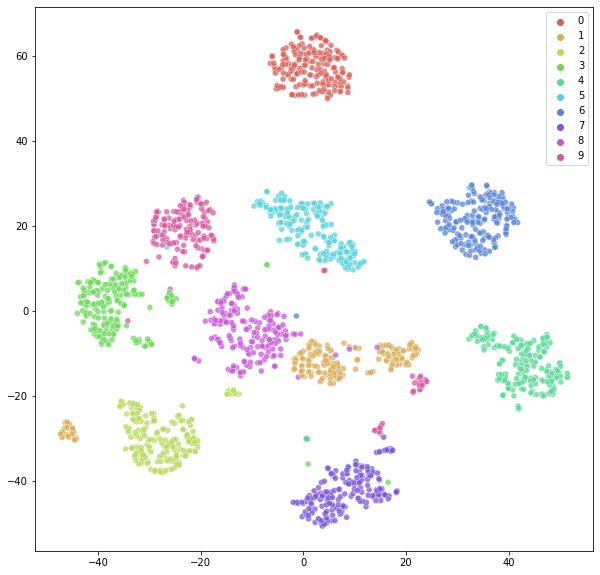

In [ ]:
# Visualize X_tsne

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)
plt.show()

## 2. Implementing t-SNE

In this exercise, we will follow the implementation of t-SNE directly from the 2008 paper by Maaten and Hinton. It builds upon SNE (Stochastic Neighbor Embedding) and "reduces the tendency to crowd points together in the center
of the map." You can find the paper on bcourses - read through the paper before you start (sections 2 and 3.3 are particularly relevant).

#### Intro/Definitions

The goal of t-SNE is to define a location $y_i$ in low-dimension space for high-dimensional points $x_i$. Each point $x_i$ has a probability distribution associated with it of picking another point $x_j$ as its neighbor, defined as $p_{j|i}$ in equation 1 of the paper. $P_i$ is defined as the probability distribution (of choosing that datapoint as the neighbor of $x_i$) across all other high-dimensional points given $x_i$. Note that  Analagously for the low-dimensional points (which we have yet to find), $Q_i$ is defined as the distribution of other low-dimensional points given $y_i$

#### Cost function description

In SNE, the cost function that we're trying to minimize is the "difference" between $P_i$ and $Q_i$ (we want them to be similar). How do we measure difference for probability distributions? The Kullback-Leibler divergence is a measure of dissimilarity between two distributions $P$ and $Q$, defined as $$ \sum_i \left( P(i) \cdot log \frac{P(i)}{Q(i)} \right) $$ for all values $i$ that $P$ and $Q$ take on. You can see how if $P = Q$ for all $i$ (same distribution), the log term will always be $\log 1 = 0$, and so the KLD will be 0 (no dissimilarity). 

As they state in the paper, "In particular, there
is a large cost for using widely separated map points to represent nearby datapoints (i.e., for using a small $q_{j|i}$ to model a large $p_{j|i}$), but there is only a small cost for using nearby map points to
represent widely separated datapoints." You can see that is true - if for some pair of points the $q$ is big and the $p$ is not, the term $$p\cdot log \frac{p}{q}$$ will be small! That will mean that it can mistranslate to low dimension sneakily without seeming like the cost is going up. That is one of the motivations behind t-SNE over SNE.

In [ ]:
#NOTE: for all the TODOs in this exercise, use numpy functions
#do NOT use for loops - they will be way too slow to run tSNE

def find_H_and_P_i(D=np.array([]), beta=1.0):
    """
    Compute the entropy (directly connected to the perplexity) and the P-row for a specific 
    datapoint x_i, given euclidean distances between x_i and every other point,
    as well as beta (the precision of the Gaussian distribution around X_i).
    
    As we see in the paper, the perplexity can be interpreted as a smooth measure of the 
    effective number of neighbors (non-integer). The entropy H is connected 
    to the perplexity through Perplexity =2**H. 
    
    Inputs:
    - D is a vector representing the squared distances of each point x_j to x_i
    - beta is 1/(2*sigma^2) - a measure of the precision of the Gaussian distribution around X_i
    
    Outputs:
    - H is the entropy (which we will use as a measure of the perplexity)
    - P_i (a vector) is the probability density representing the similarity of x_i and each neighbor x_j 
    """
    # TASK: Follow equation 1 and compute the numerators of all the p_j|i.
    
    # TODO: Assuming beta represents whatever variance division 
    # term the algorithm decides, multiply and exponentiate to get P's 
    # numerator. Check your signs!
    # Hint: No subtraction is necessary because x_j's position is 
    # treated as 0, since we are looking at the Gaussian around x_i.

    #numerator from second equation in eq 3 in paper
    P_i = np.exp((-1 * D) * beta)
        
    # computing perplexity in a vectorized + fast manner
    # it's most efficient to just find the entropy
    # https://stats.stackexchange.com/a/399328/223727
    H = np.log2(np.sum(P_i)) + beta * np.sum(D * P_i) / np.sum(P_i)
    # entropy is directly related to perplexity through Perplexity = 2**H
    
    # TODO: Normalize P_i to apply conditioning (1 line)
    P_i = P_i / np.linalg.norm(P_i)  #(P_i - np.mean(P_i, axis = 1)) / (np.var(X, axis = 1) ** 0.5)

    return H, P_i

Now we will use the perplexity (entropy) and conditional probability distributions we have computed, and brute force search for conditional Gaussians that have the same perplexity! (i.e. the $P_i$'s, or the rows of the $n$ by $n$ $P$ matrix)

A way to intuitively think about this is that we should expect any two points to estimate that the "soft" number of neighbors is the same, if they're in the same neighborhood.

In [ ]:
def find_P_from_X(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
    Performs a binary search to find the values of beta
    such that each conditional Gaussian has the same desired perplexity.
    
    Computes the values of P given these values of beta 
    and returns P.
    
    Inputs: 
    - X - an n by d matrix of the data, where n is the number of samples
        and d is the number of features
    - tol - the tolerance for H. Stop if H is within tol of the log of
        the desired perplexity
    - perplexity - the desired perplexity. Intuitively, a guess about the
        number of close neighbors each datapoint has
        
    return:
    - P - a matrix where each row is the probability density that
        represents how likely x_i is to choose each other datapoint x_j
        as its neighbor    
    """
    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)

    # NOTE: the P you compute should be of this shape. 
    # Make sure you understand why!
    P = np.zeros((n, n))
    beta = np.ones((n, 1))

    # NOTE: the log of the perplexity is our target entropy
    logU = np.log2(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        # np.r_ just efficiently concatenates along the row
        # https://stackoverflow.com/a/30597960/10302846
        D_i = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        
        # TODO: Utilize your newly written function to get perplexity and Pvals 
        # (1 line)
        H, P_i = find_H_and_P_i(D_i, beta[i])

        # TODO: Evaluate whether the perplexity is within tolerance - use logU (1 line)
        H_diff = tol - (2**logU)
        # Hint - don't apply absolute value yet - we need to know the sign
        # of this value for binary search! You can apply abs in the loop cond.

        tries = 0
        
        # TODO:
        # Write a loop condition that continues if we're both below the max
        # number of tries (50), and the absolute difference is greater than 
        # the tolerance.

        while tries < 50 and H_diff > tol :

            # TASK: If not, increase or decrease the precision (beta)
            # What follows here is a version of the standard binary search checks.
            # The idea is that if we're too high (H_diff positive), we can set the 
            # new min to be our current beta, and move our beta towards the max.
            # If the max is currently infinity, we should just double beta.
            # If the max is an actual number, set beta to be the avg of it and max.

            if H_diff > 0: # H_diff is positive
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    # adjust the beta
                    # TODO: 
                    beta[i] = beta[i] * 2
                else:
                    # adjust the beta
                    # TODO: 
                    beta[i] = (beta[i] + betamax) / 2
            else:
                # Opposite of above (if H_diff is negative)
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    # TODO: 
                    beta[i] = beta[i] * 2
                else:
                    # TODO: 
                    beta[i] = (betamin + beta[i])/2

            # TODO: Recompute the values again using your function and the new betas
            H, thisP = find_H_and_P_i(D[i], beta)
            
            # TODO: Recompute H_diff
            # (same as "Evaluate whether the perplexity is within tolerance")
            # Perplexity = 2**H
            H_diff = tol - (2 ** H)
            
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = P_i

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(0.5 / beta)))
    return P

In [ ]:
def pca(X=np.array([]), n_dims=50):
    """ Runs PCA on the NxD array X in order to reduce its dimensionality to
        n_dims dimensions. """
   
    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:n_dims])
    return Y

Now, we will use the Student t-distribution with one degree of freedom to compute $Q$, the matrix of joint probabiltiies in low dimensions (see equation 4 of the paper).

When calculating the numerator of $Q$ note that $ \lVert y_i - y_j \rVert^2 $ can be expanded as $y_i^{T} y_i - 2y_i^T y_j + y_j^T y_j$.

In [55]:
def tsne(X=np.array([]), n_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to n_dims dimensions. 
        
        Uses PCA to reduce X to initial_dims dimensions, first.
    """

    # Check inputs
    if isinstance(n_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(n_dims) != n_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape # shape 1797x50
    max_iter = 400
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, n_dims)   # shape 1797x2
    dY = np.zeros((n, n_dims))
    iY = np.zeros((n, n_dims))
    gains = np.ones((n, n_dims))
    tolerance = 1e-5
    
    #TODO:
    # Compute P-values using your previous function
    # remember to pass tolerance and perplexity to the function
    P = find_P_from_X(X, tol = 1e-5, perplexity=30.0)
    
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4    # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):
        # TASK: Compute pairwise affinities (Q)  # SUBTASK: compute the numerator `num`
        
        #TODO: first, find the norm squared 
        
        #Hints:
        # look at the expansion of norm squared in the above cell
        # To find the matrix of norm squared, you can find a matrix for each term and sum them together
        # For the first and third terms, you will need to use np.square and np.sum, consider the orientation of Y : is y_i a row or a column?
        # For the middle (-2) term, you will need to compute the outer product of Y with itself (use np.dot)
        #remember - do NOT use for loops - they will be too slow

        ft = np.sum(np.square(Y), axis=1)     # shape is (1797,)
        middle = -2 * np.dot(Y, np.transpose(Y))   # shape 1797x1797 
        norm_sq = np.add(np.add(middle, ft).T, ft)   # shape is (1797,1797)

        #TODO: next, find the numerator using norm_sq - look at equation 4 in pdf
        # ^ last hint: we already had to find squared distances elsewhere in the code, for ||x_i - x_j||^2
        num = 1 / (1 + norm_sq)  # shape 1797x1797
        
        # END OF SUBTASK     

        # TODO: set the diagonal of numerator to 0 (because q_ii = 0), and normalize it to get Q
        # you can index into matrix using [range(a), range(a)] to get the diagonal elements
        # (2 lines)
        num[range(len(num)), range(len(num))] = 0 # all good  # shape 1797x1797
        Q = num / np.sum(num)

        # END OF TASK
        
        # this makes Q nonzero/non-negative, because floats are terrible
        Q = np.maximum(Q, 1e-12) # shape 1797x1797

        # Compute gradient
        # print(P.shape,Q.shape)
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (n_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            # TODO: Implement KL Divergence cost function on P and Q

            C = np.sum(P * np.log(P / Q))
            # HINT: make sure you wrap it with an np.sum so it's a scalar

            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop exaggerating about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P for point 0 of 1797...
Computing P for point 500 of 1797...
Computing P for point 1000 of 1797...
Computing P for point 1500 of 1797...
Mean value of sigma: 0.707107
Iteration 10: error is 14.901131
Iteration 20: error is 12.805089
Iteration 30: error is 11.675563
Iteration 40: error is 11.537189
Iteration 50: error is 11.622211
Iteration 60: error is 11.679958
Iteration 70: error is 11.680796
Iteration 80: error is 11.673810
Iteration 90: error is 11.669975
Iteration 100: error is 11.668334
Iteration 110: error is 1.071995
Iteration 120: error is 0.754437
Iteration 130: error is 0.645623
Iteration 140: error is 0.592837
Iteration 150: error is 0.563010
Iteration 160: error is 0.543792
Iteration 170: error is 0.530587
Iteration 180: error is 0.521141
Iteration 190: error is 0.514353
Iteration 200: error is 0.509499
Iteration 210: error is 0.505906
Iteration 220: error is 0.503172
Iteration 230: error is 0.5

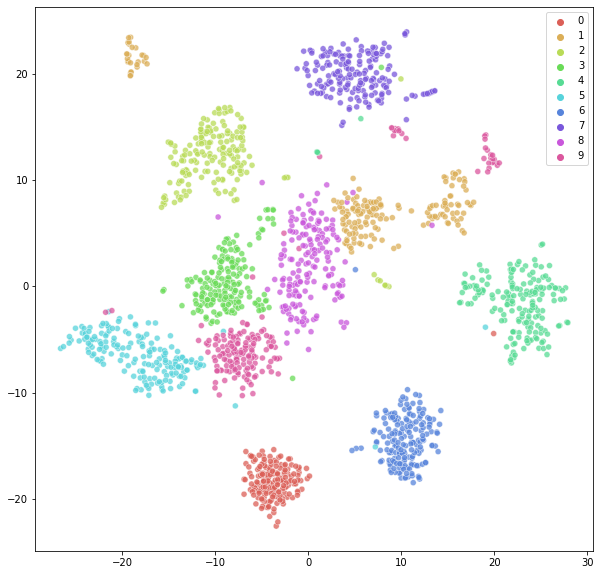

In [56]:
# Run TSNE again to check that the implementation's output matches the library version's output!

X_tsne = tsne(X)
# X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)
plt.show()

If your implementation is correct, you should see good separation much like the run in Question 1, though the shapes and locations of the clusters likely won't be the same (due to our implementation and parameters differing slightly from the sklearn t-SNE).

## 3. Conceptual Questions

### 3.a) To optimize the performance of the method, we scaled P by 4 for the first 100 iterations of gradient descent. How does this improve performance?

see: Section 3.4 in the paper

  Scaling P by 4 for the first 100 iterations of gradient descent improves performance because the optimization is guided to model large p_ij's by larger q_ij's. This results in the clusters being able to move around easier and be better organized due to more empty space in the map and more separation between clusters. This method to improve optimization is called "early exaggeration”.

### 3.b) In the above implementation, we used PCA to first reduce the input to 50 dimensions/features - why is it preferred to run t-SNE on data that doesn't have a high number of dimensions?

see: Section 6.2, number 2 in the paper

  It is preferred to run t-SNE on data that doesn't have a high number of dimensions, because with data sets of high intrinsic dimensionality and a highly varying underlying manifold, you can no longer count on the assumption that you can use Euclidean distances between nearest neighbors for local linearity of the manifold. (t-SNE reduces the dimensionality of data based on local properties)

  This problem can be addressed somewhat by using autoencoder or other nonlinear layers, because autoencoders can recognize manifolds with high variability better than t-SNE.

### 3.c) t-SNE is known to be a 'nonlinear' dimensionality reduction method. As such the distance between points does not accurately reflect distance in the original space. Based on the math behind the technique, explain why t-SNE is nonlinear.

see: Section 2 in the paper

This method converts higher dimensional Euclidean distances between data into conditional probabilities that represent similarities. The similarity between point xj and xi is the conditional probability p j|i. pj|i is the probability that xi would pick xj as its neighbor according to the Gaussian probability density distribution centered at xi with variance σi. For data points nearby to xi, pj|i is high. This conditional probability does not deal with linear distances only; from the equation we see that both the numerator and denominator deal have e to the power of the squared Euclidean distances (multiplied by some other elements of course) and not solely a linear computation.

$$p_{i j} = \frac{\text{exp}(-||x_i - x_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i}\text{exp}(-||x_i - x_k||^2/ 2\sigma_i^2)} $$

You can also compute a conditional proabability q j|i for the low dimensional counterparts yi and yj of xi and xj, with variance of gaussian 1√2. Using the same variance for every point in the low dimensional map results in the loss of the property that the data is a perfect model of itself, since for high dimensional space we would use a different variance in each Gaussian. This conditional probability also does not deal with linear distances only; from the equation we see that both the numerator and denominator deal have e to the power of the squared Euclidean distances (multiplied by negative one of course) and not solely a linear computation.

$$q_{i j} = \frac{\text{exp}(-||y_i - y_j||^2)}{\sum_{k \neq i}\text{exp}(-||y_i - y_k||^2)} $$

The error between p j|i and q j|i is given by the Kullback-
Leibler cost function, so that SNE aims to minimize the sum of these divergences using gradient descent. The Kullback-Leibler cost function is not symmetric, so dfferent errors in pairwise distances for the low dimensional map don't carry the same weightage. Map points with more separation carry more cost to represent nearby points but map points closer together carry less cost to represent nearby map points. This is because the cost function focuses on retaining the local structure of the data in the map, instead of the global structure, so the distances vetween points doesn't accurately reflect distance in the orginal space (see by the effects on the cost function above). The cost function is no longer least squared error like for linear regression, but rather cross entropy loss. Even in the gradient descent, to improve optimization, the current gradient is added to the exponentially decaying sume of previous gradients, which is non-linear.

### 3.d) Explain the improvement of this method over SNE - specifically, why is the distance between two points in the lower-dimensional space defined as (1) rather than the definition of distance used for the higher dimensional space (2), **ignoring the symmetrization?**


$$q_{i j} = \frac{(1+||y_i - y_j||^2)^{-1}}{\sum_{k \neq l}(1+||y_k - y_l||^2)^{-1}} \;\;\;\;\;\;  (1)$$

$$p_{i j} = \frac{\text{exp}(-||x_i - x_j||^2 / 2\sigma^2)}{\sum_{k \neq l}\text{exp}(-||x_k - x_l||^2/ 2\sigma^2)} \;\;\;\;\;\;  (2)$$

see: Section 3 in the paper

The distance between two points in the lower-dimensional space is defined as (1) rather than the definition of distance used for the higher dimensional space (2).

Equation (2) in SNE method using the Gaussian distribution has problems when pairwise distances in higher dimensions are extremely large, making the values of p_ij really small. This means that the location of p_ij's low dimensional map point y_i will not affect the cost function very much at all, resulting in that location of the low dimensional map point not being well determined by the locations of other low dimenisonal map points.

Whereas equation (1) in t-SNE method uses the t-distribution so that (1 + ‖yi − y j‖^2)^(-1) makes the low dimensional map's representation of joint probabilities resitant to changes in the scale of the map for points that are very far apart. Points very far apart interact similar to points close together (unlike SNE with equation (2)) so optimization works the same way and location of map points will be well determined by locations of other map points.

###Save this notebook as a pdf and submit to gradescope!